### Add model, connection and device to settings:

In [7]:
# библиотеки
import os
import sys
import inspect
import numpy as np
import re
import math
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from hybriddomain.envs.hs.model.model_main import ModelNet as Model
from hybriddomain.settings.settings_main import Settings
from ddeint import ddeint

# пути и названия файлов
modelFileName = 'problems/delay_equation1'
conn_name = "connection.json"
device_conf_name = "devices.json"

#Ввод пароля для инициализации пользователя
model = Model()
model.io.loadFromFile(modelFileName)
settings = Settings(model, conn_name, device_conf_name, conn_name)

INFO:block_main.block_io:DefaultBound not set
INFO:settings_main:device_conf_rpath
INFO:settings_main:devices.json


Please enter password for user imaslenikov:


 ·········


### Run solver:

In [8]:
# запуск процесса решения уравнения
from hybriddomain.solvers.hs.remoterun.progresses.progress_notebook import ProgressNotebook
progress = ProgressNotebook(100, prefix='solving')
from hybriddomain.solvers.hs.remoterun.remoterun import remoteProjectRun

clear_output()
test_name = settings.paths['model']['name']
bTest = widgets.Button(description="run %s " % (test_name))
def run(event):
    remoteProjectRun(settings, 1, progress)
bTest.on_click(run)
display(progress.progress)
remoteProjectRun(settings, 1, progress)
#display(bTest)

IntProgress(value=0, description='solving: ', max=99)

INFO:remoterun:
connect ...
INFO:remoterun:
connection established
INFO:remoterun:
files/folders routine
INFO:remoterun:
files/folders routine completed
INFO:remoterun:
Running preprocessor:
INFO:remoterun:command:
INFO:remoterun:~/anaconda3/bin/python3 -c "import hybriddomain.gens.hs.tests.tests_gen_1d as ts; ts.run()" -t /acchome/imaslenikov/tracer/workspace/problems/delay_equation1 -d /acchome/imaslenikov/tracer/workspace/settings/device_conf/devices.json -p /acchome/imaslenikov/tracer/workspace/settings/paths/connection.json -w /acchome/imaslenikov/tracer/workspace -u imaslenikov 2>&1
INFO:remoterun:
Running solver:
INFO:remoterun:01-28 09:49:48 Performance (10^6): 0.00302515

INFO:remoterun:INFO:postproc.video:Creating images for block 0 value U

INFO:remoterun:INFO:postproc.video:Creating video file: 0

INFO:remoterun:INFO:postproc.video:Creating out file: u

INFO:remoterun:Downloading results...
INFO:remoterun:Done!


### Results:

In [9]:
# объекте model хранится вся информация по решению задачи
# get results (for TRAC-11 result_format=1):
model.readResults(result_format=1)
model.results_paths
# available results:
print(model.results_arrays.keys())

dict_keys(['u'])


### Video:

In [10]:
# available plots:
model.plots_paths

{'u': ['problems/delay_equation1/out/u.mp4']}

In [11]:
display(HTML(model.get_video('u')))

### U(x, t-fixed),V(x, t-fixed):

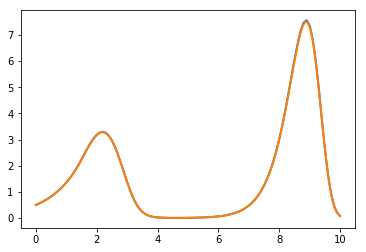

In [14]:
# отрисовывает результат
%matplotlib inline
time = model.results_arrays['u']['timevalues']

times = model.results_arrays['u']['timevalues']

result = model.results_arrays['u']['resvalues']
result_x = np.array([result[time][0][1] for time in times])
plt.plot(time, result_x, lw=2)


b = 1
h = 1.5
a = 2

def model1(Y,t,d):
    y=Y(t)
    yd=Y(t-h)
    return np.array([a * (1 -  yd) * y])
g=lambda t : 0.5

#model1 = lambda Y,t, k,h,r :  a * (1 - ( Y(t-h)/b)) * Y(t)
#g = lambda t: t+1 # history before t=0
tt = np.linspace(0,10,10001)
for d in [0,0.2]:
    answer_DDE = ddeint(model1, g, tt, fargs=(d,)) # K=0.1, d=5, r=1
plt.plot(tt, answer_DDE, lw=2)
plt.show()


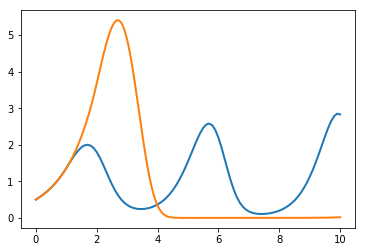

In [9]:
# отрисовывает результат
%matplotlib inline
time = model.results_arrays['u']['timevalues']

times = model.results_arrays['u']['timevalues']

result = model.results_arrays['u']['resvalues']
result_x = np.array([result[time][0][1] for time in times])
plt.plot(time, result_x, lw=2)


b = 1
h = 2
a = 2

def model1(Y,t,d):
    y=Y(t)
    yd=Y(t-h)
    return np.array([a * (1 -  yd) * y])
g=lambda t : 0.5

tt = np.linspace(0,10,10001)
for d in [0,0.2]:
    answer_DDE = ddeint(model1, g, tt, fargs=(d,)) # K=0.1, d=5, r=1
plt.plot(tt, answer_DDE, lw=2)
plt.show()


In [8]:
# отрисовывает отклонение нашего решения от решения DDE
%matplotlib inline

time = model.results_arrays['U']['timevalues']
times = model.results_arrays['U']['timevalues']
result = model.results_arrays['U']['resvalues']

result_x = np.array([result[time][0][1] for time in times])
b = 2
h = 1
a = 1

def model1(Y,t,d):
    y=Y(t)
    yd=Y(t-h)
    return np.array([a * (1 - ( yd/b)) * y])
g=lambda t : t+1

#количество точек для использования построения решения
tt =np.linspace (0.0,10.0,10001)
for d in [0,0.2]:
    answer_DDE = ddeint (model1,g,tt,fargs=(d,))
#print(time)
i = 0
find_error = []
for poi in time:
    b = abs(answer_DDE[i*100]-result_x[i])
    find_error.append(b)
    i+=1
plt.plot(time, find_error)


plt.show()



KeyError: 'U'